# Part 3: Serving

In this part we will use MLRun's **serving runtime** to deploy our trained models from the previous stage a `Voting Ensemble` using **max vote** logic.
We will also use MLRun's **Feature store** to receive the latest tag of the online **Feature Vector** we defined in the preveious stage.

By the end of this tutorial you’ll learn how to:
- Define a model class to load our models, run preprocessing and predict on the data
- Define Voting Ensemble function on top of our models
- Test the serving function locally using our `mock server`
- Deploy the function to the cluster and test it live

## Environment Setup

First, we will make sure SciKit-Learn is installed in the correct version:

In [1]:
!pip install -U scikit-learn

Restart your kernel post installing.
Secondly, since our work is done in this project scope, we will want to define the project itself for all our MLRun work in this notebook.

In [2]:
project_name = 'fraud-demo'

In [3]:
import mlrun

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2023-02-09 13:26:03,799 [info] loaded project fraud-demo from MLRun DB


## Define Model Class
- Load models
- Predict from the feature store online service via the `source` key

In [4]:
# mlrun: start-code

In [5]:
import numpy as np
from cloudpickle import load
from mlrun.serving.v2_serving import V2ModelServer

class ClassifierModel(V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))
        
    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        print(f"Input -> {body['inputs']}")
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [6]:
# mlrun: end-code

## Define a Serving Function

MLRun serving can produce managed real-time serverless pipelines from various tasks, including MLRun models or standard model files.
The pipelines use the Nuclio real-time serverless engine, which can be deployed anywhere.
[Nuclio](https://nuclio.io/) is a high-performance open-source serverless framework that's focused on data, I/O, and compute-intensive workloads.

The **EnrichmentVotingEnsemble** and the **EnrichmentModelRouter** router classes auto enrich the request with data from the feature store.
the router input accept list of inference request (each request can be a dict or list of incoming features/keys), it enriches the request with data from the specified feature vector (`feature_vector_uri`).

In many cases the features can have null values (None, NaN, Inf, ..), the `Enrichment` routers can substitute the null value with fixed or statistical value per feature, this is done through the `impute_policy` parameter which accepts the impute policy per feature (where `*` is used to specify the default), the value can be fixed number for constants or `$mean`, `$max`, `$min`, `$std`, `$count` for statistical values. to substitute the value with the equivalent feature stats (taken from the feature store).  

In the code below we perform the following steps:

- Gather ClassifierModel code from this notebook
- Define `EnrichmentVotingEnsemble` - Max-Vote based ensemble with feature enrichment and imputing
- Add the previously trained models to the ensemble

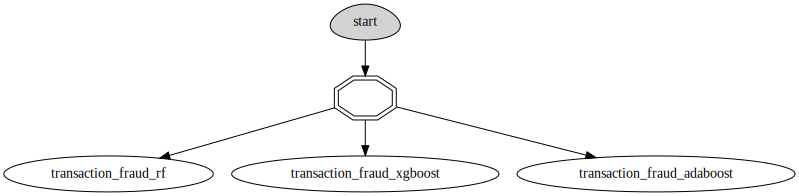

In [7]:
# Create the serving function from our code above
serving_fn = mlrun.code_to_function('transaction-fraud', kind='serving', image="mlrun/mlrun")

serving_fn.set_topology('router', 'mlrun.serving.routers.EnrichmentVotingEnsemble', name='VotingEnsemble',
                        feature_vector_uri="transactions-fraud-short", impute_policy={"*": "$mean"})

model_names = [
'transaction_fraud_rf',
'transaction_fraud_xgboost',
'transaction_fraud_adaboost'
]
for i, name in enumerate(model_names, start=1):
    serving_fn.add_model(name, class_name="ClassifierModel", model_path=project.get_artifact_uri(name))

# Plot the ensemble configuration
serving_fn.spec.graph.plot()

## Test the server locally

Before deploying the serving function, we can test it in the current notebook and check the model output

In [ ]:
project.list_artifacts()

In [9]:
# Create a mock server from the serving function
local_server = serving_fn.to_mock_server()

> 2023-02-09 13:26:08,454 [info] model transaction_fraud_rf was loaded
> 2023-02-09 13:26:08,540 [info] model transaction_fraud_xgboost was loaded
> 2023-02-09 13:26:08,623 [info] model transaction_fraud_adaboost was loaded


In [10]:
# Choose an id for our test
sample_id = 'C1000148617'

model_inference_path = '/v2/models/infer'

# Send our sample ID for predcition
local_server.test(path=model_inference_path,
            body={'inputs': [[sample_id]]})

# notice the input vector is printed 3 times (once per child model) and is enriched with data from the feature store

Input -> [[87.35070680000041, 9.506061600000022, 36.605924197824514, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Input -> [[87.35070680000041, 9.506061600000022, 36.605924197824514, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Input -> [[87.35070680000041, 9.506061600000022, 36.605924197824514, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names


{'id': 'ae58930fd10c4d0c91ef062185fa2514',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

### Accessing the real-time feature vector directly

We can also directly query the feature store values using the `get_online_feature_service` method, this method is used internally in the EnrichmentVotingEnsemble router class

In [11]:
import mlrun.feature_store as fstore

# Create the online feature service
svc = fstore.get_online_feature_service('transactions-fraud-short:latest', impute_policy={"*": "$mean"})

# Get sample feature vector
sample_fv = svc.get([{'source': sample_id}])
sample_fv

[{'amount_max_2h': 87.35070680000041,
  'amount_min_2h': 9.506061600000022,
  'es_transportation_sum_1d': 0.0,
  'es_health_sum_1d': 0.0,
  'es_otherservices_sum_1d': 0.0,
  'es_food_sum_1d': 0.0,
  'es_hotelservices_sum_1d': 0.0,
  'es_barsandrestaurants_sum_1d': 0.0,
  'es_tech_sum_1d': 0.0,
  'es_sportsandtoys_sum_1d': 0.0,
  'es_wellnessandbeauty_sum_1d': 0.0,
  'es_hyper_sum_1d': 0.0,
  'es_fashion_sum_1d': 0.0,
  'es_home_sum_1d': 0.0,
  'amount_avg_2h': 36.605924197824514}]

## Deploying the function on the kubernetes cluster

We can now deploy the function, once deployed we will get a function with http trigger that can be called from other locations.

In [12]:
import os

# Enable model monitoring
serving_fn.set_tracking()
project.set_model_monitoring_credentials(os.getenv('V3IO_ACCESS_KEY'))

# Deploy the serving function
serving_fn.deploy()

> 2023-02-09 13:26:09,049 [info] Starting remote function deploy
2023-02-09 13:26:11  (info) Deploying function
2023-02-09 13:26:11  (info) Building
2023-02-09 13:26:11  (info) Staging files and preparing base images
2023-02-09 13:26:11  (info) Building processor image
2023-02-09 13:27:36  (info) Build complete
2023-02-09 13:28:35  (info) Function deploy complete
> 2023-02-09 13:28:35,268 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-dani-transaction-fraud.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['fraud-demo-dani-transaction-fraud-fraud-demo-dani.default-tenant.app.vmdev94.lab.iguazeng.com/']}


'http://fraud-demo-dani-transaction-fraud-fraud-demo-dani.default-tenant.app.vmdev94.lab.iguazeng.com/'

## Test the Server

We can test the serving function and examine the model output

In [13]:
# Choose an id for our test
sample_id = 'C1000148617'

model_inference_path = '/v2/models/infer'

# Send our sample ID for predcition
serving_fn.invoke(path=model_inference_path,
                  body={'inputs': [[sample_id]]})

> 2023-02-09 13:28:35,324 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-dani-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}


{'id': 'ce0f1ddb-1f74-456a-b658-f6d6b8f4cd68',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

We can also directly query the feature store values, which is used in the enrichment

### Simulate incoming data

In [14]:
# Load the dataset
data = mlrun.get_dataitem('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv').as_df()

# use only first 50k
data = data.sort_values(by='source', axis=0)[:50000]

# keys
sample_ids = data['source'].to_list()

In [15]:
from random import choice, uniform
from time import sleep

# Sending random requests
for _ in range(10):
    data_point = choice(sample_ids)
    try:
        resp = serving_fn.invoke(path=model_inference_path, body={'inputs': [[data_point]]})
        print(resp)
        sleep(uniform(0.2, 1.7))
    except OSError:
        pass

> 2023-02-09 13:29:27,685 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-dani-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}
{'id': 'a72cff5e-633b-4e38-9d31-21ccd6ca94b8', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2023-02-09 13:29:29,530 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-dani-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}
{'id': '4eaddc83-a36a-4bd1-b5bd-0849c9320023', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2023-02-09 13:29:30,395 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-dani-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}
{'id': '5e4994ba-2c3b-4b22-8c09-e970b6aa8890', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2023-02-09 13:29:31,002 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-

## Done!

You've completed Part 3 of the deploying the serving function.
Proceed to [Part 4](04-pipeline.ipynb) to learn how to automate ML Pipeline.

